# Week 12: Social Network Analysis

# Rasika Bhalerao

# Agenda

- Intro graph
- Make a graph given a "friends" matrix
- Louvain clustering for network detection
- Let's graph words!

In [79]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import community.community_louvain as community_louvain
import gensim.downloader as api
from gensim.models import Word2Vec
import re
import random
# !pip install python-Levenshtein
from Levenshtein import distance

### Intro graph

In [5]:
# Let's create a graph!

G = nx.Graph()

G.add_node('biased news articles')
G.add_node('articles of confederation')
G.add_node('news of biased articles')

G.add_edge('biased news articles', 'articles of confederation')
G.add_edge('biased news articles', 'news of biased articles')
G.add_edge('articles of confederation', 'news of biased articles')

print(G.nodes())
print(nx.adjacency_matrix(G).toarray())

['biased news articles', 'articles of confederation', 'news of biased articles']
[[0 1 1]
 [1 0 1]
 [1 1 0]]


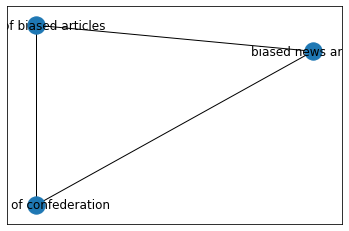

In [16]:
node_position = nx.spectral_layout(G)
# node_position = nx.spring_layout(G)

# draw the nodes
nx.draw_networkx_nodes(G, node_position)

# draw the edges
nx.draw_networkx_edges(G, node_position)

# draw the labels
nx.draw_networkx_labels(G, node_position)
    
plt.show()

### Make a graph given a "friends" matrix

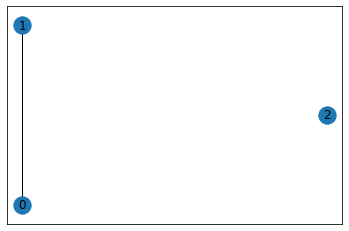

In [22]:
# Represent friends using an adjacency matrix
#       item [i, j] represents the "strength" of i and j's friendship
#       if they are not friends, it is 0
#       if they are the best of friends, it is super high
# Note: this is symmetric
#       A's friendship with B is B's friendship with A
#       so this is a weighted undirected graph


# test 1
A = np.array([[0, 3, 4], 
              [3, 0, 0],
              [4, 0, 0]])

# test 2
A = np.array([[0, 1, 2, 0, 0, 0, 0, 0, 0],
              [1, 0, 1, 0, 2, 3, 0, 0, 0],
              [2, 1, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 4, 0, 2, 0, 0],
              [0, 2, 1, 4, 0, 0, 2, 2, 0],
              [0, 3, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 2, 2, 0, 0, 0, 2],
              [0, 0, 0, 0, 2, 1, 0, 0, 1],
              [0, 0, 0, 0, 0, 0, 2, 1, 0]])

G = nx.Graph()

num_nodes = 3                                # FIX THIS LINE
    
for i in range(num_nodes):
    G.add_node(str(np.random.randint(5)))    # FIX THIS LINE

for i in range(num_nodes):
    for j in range(i, num_nodes):
        if A[i, j] is not None:              # FIX THIS LINE
            G.add_edge('0', '1', weight=4)   # FIX THIS LINE

node_position = nx.spectral_layout(G)
nx.draw_networkx_nodes(G, node_position)
nx.draw_networkx_edges(G, node_position)
nx.draw_networkx_labels(G, node_position)
plt.show()

### Louvain clustering for network detection

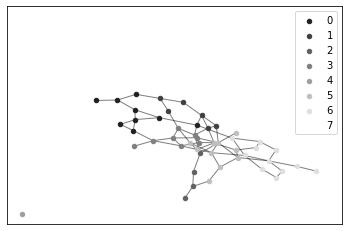

In [23]:
# Create graph with 50 nodes, and prob 0.05 for each possible edge
G = nx.erdos_renyi_graph(50, 0.05)

partition = community_louvain.best_partition(G)

size = float(len(set(partition.values())))
pos = nx.spring_layout(G)

# draw nodes
count = 0.
for com in set(partition.values()):
  count = count + 1.
  list_nodes = [
                nodes for nodes in partition.keys()
                if partition[nodes] == com
  ]
  nx.draw_networkx_nodes(
      G, pos, list_nodes, node_size = 20,
      node_color = str(count / size),
      label= com
  )

# draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.legend(loc=1)
plt.set_cmap('rainbow')
plt.show()

In [26]:
# modularity describes how the density within clusters
# compares to density between clusters
# -1/2 means the clusters are not well defined
# 1 means the clusters are perfect

community_louvain.modularity(partition, G)

0.5432653061224489

In [28]:
# print the nodes in each cluster

values = partition.values()
for cc in set(values):
    print (cc, np.flatnonzero(np.array(list(values))== cc))

0 [ 0  3  6 14 25 31 38 44 49]
1 [15 19 34 43 47 48]
2 [13 16 17 23]
3 [10 12 18 22 30 36 37 40]
4 [4]
5 [ 1  5  7  9 11 20 26 28 29 41]
6 [ 2  8 21 24 27 32 33 39 42 45 46]
7 [35]


### Let's graph words!

In [31]:
# Dataset: word2vec embeddings learned from newspapers

corpus = [sentence['data'] for sentence in api.load('20-newsgroups')]
corpus = [
          [re.sub(r'\W+', '', word) for word in sentence.strip().split()]
          for sentence in corpus
]
corpus = [[word for word in sentence if len(word) > 0] for sentence in corpus]
vocab = list(set(word for sentence in corpus for word in sentence))

w2v = Word2Vec(sentences=corpus, size=50, window=5, min_count=1, workers=-1)

[==================================================] 100.1% 13.8/13.8MB downloaded


In [75]:
# the nodes are the words in the vocab
# the weight of the edge between word i and j is the semantic similarity
#     dot product between their vectors, times 10
#     0 if the dot product is <= 0

# for simplicity, let's use a small vocab
mini_vocab = random.sample(vocab, 50)

G = nx.Graph()

for word in mini_vocab:
  G.add_node(word)

for word1 in mini_vocab:
  for word2 in mini_vocab:
    if word1 != word2:
      weight = np.dot(w2v.wv[word1], w2v.wv[word2])*10
      if weight > 0:
        G.add_edge(
            word1, word2,
            weight=weight
        )


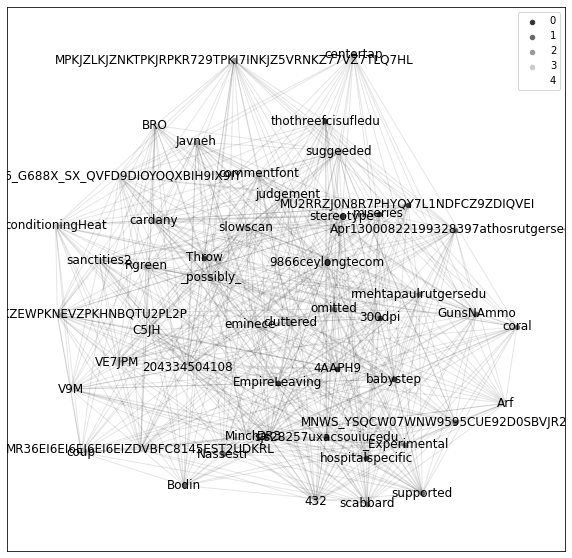

In [76]:
# graph the clustering!

partition = community_louvain.best_partition(G)

size = float(len(set(partition.values())))
pos = nx.spring_layout(G)

plt.figure(figsize=(10,10))

# draw nodes/labels
count = 0.
for com in set(partition.values()):
  count = count + 1.
  list_nodes = [
                nodes for nodes in partition.keys()
                if partition[nodes] == com
  ]
  nx.draw_networkx_nodes(
      G, pos, list_nodes, node_size = 20,
      node_color = str(count / size),
      label= com
  )
  nx.draw_networkx_labels(G, pos, {i:i for i in list_nodes})

# draw edges
nx.draw_networkx_edges(G, pos, alpha=0.1)

plt.legend(loc=1)
plt.set_cmap('rainbow')
plt.show()

In [87]:
# Activity:
#      modify the code so that edge weights are levenshtein "similarity"
#      which is 1 - (levenshtein_dist / len(bigger_word))
#      and use/add to the following list of words


word_list = [
           'provable',
           'probable',
           'preferable',
           'cat',
           'caat'
]

def get_weight(word1, word2):
  max_len = max(len(word1), len(word2))
  return 1 - (distance(word1, word2) / max_len)

G = nx.Graph()

for word in word_list:
  # ADD CODE HERE

for word1 in word_list:
  for word2 in word_list:
    if word1 != word2:
      # ADD CODE HERE

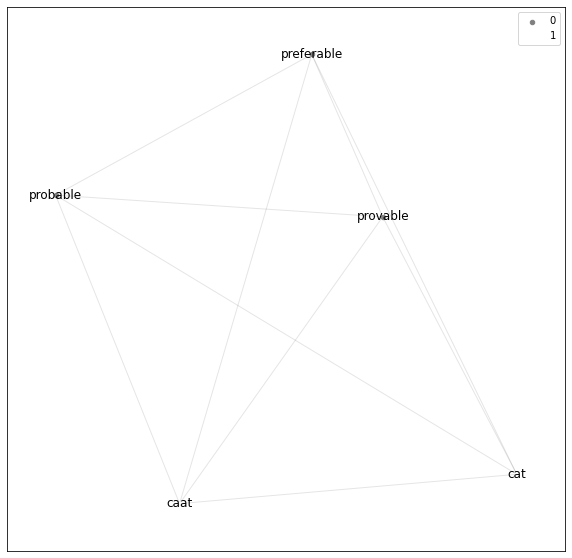

In [88]:
partition = community_louvain.best_partition(G)

size = float(len(set(partition.values())))
pos = nx.spring_layout(G)

plt.figure(figsize=(10,10))

# draw nodes/labels
count = 0.
for com in set(partition.values()):
  count = count + 1.
  list_nodes = [
                nodes for nodes in partition.keys()
                if partition[nodes] == com
  ]
  nx.draw_networkx_nodes(
      G, pos, list_nodes, node_size = 20,
      node_color = str(count / size),
      label= com
  )
  nx.draw_networkx_labels(G, pos, {i:i for i in list_nodes})

# draw edges
nx.draw_networkx_edges(G, pos, alpha=0.1)

plt.legend(loc=1)
plt.set_cmap('rainbow')
plt.show()